In [4]:
# Install required packages
!pip install transformers torch torchvision torchaudio
!pip install pandas numpy scikit-learn matplotlib seaborn
!pip install accelerate -U  # For better training

In [5]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Load dataset
import io
df = pd.read_csv('hindi_preprocessed_data.csv')

# If you already have the file in your environment
# df = pd.read_csv('your_dataset.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nLabel distribution:")
print(df['label'].value_counts())
print(f"\nLabel encoded distribution:")
print(df['label_encoded'].value_counts())

# Create mapping for labels
label_mapping = {
    0: 'hate',
    1: 'normal',
    2: 'offensive'
}

# Reverse mapping
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

print(f"\nLabel Mapping: {label_mapping}")

Dataset shape: (5981, 8)
Columns: ['text_id', 'text', 'task_1', 'task_2', 'task_3', 'label', 'clean_text', 'label_encoded']

Label distribution:
label
normal       2907
hate         2201
offensive     873
Name: count, dtype: int64

Label encoded distribution:
label_encoded
1    2907
0    2201
2     873
Name: count, dtype: int64

Label Mapping: {0: 'hate', 1: 'normal', 2: 'offensive'}


In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Initialize tokenizer (using XLM-RoBERTa which works well with Hindi)
MODEL_NAME = "xlm-roberta-base"  # You can also use "ai4bharat/indic-bert"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Check max sequence length
print(f"Tokenizer max length: {tokenizer.model_max_length}")

# Create train-test split
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label_encoded']
)

val_df, test_df = train_test_split(
    test_df,
    test_size=0.5,
    random_state=42,
    stratify=test_df['label_encoded']
)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Tokenizer max length: 512
Train size: 4784
Validation size: 598
Test size: 599


In [8]:
class HindiTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Prepare data for datasets
train_texts = train_df['clean_text'].values
train_labels = train_df['label_encoded'].values

val_texts = val_df['clean_text'].values
val_labels = val_df['label_encoded'].values

test_texts = test_df['clean_text'].values
test_labels = test_df['label_encoded'].values

# Create datasets
train_dataset = HindiTextDataset(train_texts, train_labels, tokenizer)
val_dataset = HindiTextDataset(val_texts, val_labels, tokenizer)
test_dataset = HindiTextDataset(test_texts, test_labels, tokenizer)

# Create dataloaders
batch_size = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(val_loader)}")

Number of batches in train loader: 299
Number of batches in validation loader: 38


In [9]:
from transformers import AutoModelForSequenceClassification
import torch.nn as nn

# Initialize model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,  # hate, normal, offensive
    ignore_mismatched_sizes=True
)

# Move model to device
model = model.to(device)

# Print model architecture
print(model.config)
print(f"\nModel has {sum(p.numel() for p in model.parameters()):,} parameters")

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "dtype": "float32",
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}


Model has 278,045,955 parameters


In [11]:
from transformers import get_linear_schedule_with_warmup
# For newer versions of transformers, use torch.optim.AdamW
from torch.optim import AdamW

# Training parameters
EPOCHS = 5
LEARNING_RATE = 2e-5

# Optimizer - using torch's AdamW
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

# Alternative: If you want to use the transformers version (if available in older versions)
# try:
#     from transformers import AdamW
#     optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
# except ImportError:
#     from torch.optim import AdamW
#     optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

# Total training steps
total_steps = len(train_loader) * EPOCHS

# Scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Function to calculate accuracy
def calculate_accuracy(preds, labels):
    _, predicted = torch.max(preds, dim=1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / len(labels)
    return accuracy

# Function for training one epoch
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model = model.train()
    total_loss = 0
    total_accuracy = 0

    progress_bar = tqdm(data_loader, desc="Training")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Calculate loss
        loss = loss_fn(logits, labels)

        # Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update parameters
        optimizer.step()
        scheduler.step()

        # Calculate accuracy
        accuracy = calculate_accuracy(logits, labels)

        total_loss += loss.item()
        total_accuracy += accuracy

        # Update progress bar
        progress_bar.set_postfix({
            'loss': loss.item(),
            'accuracy': accuracy
        })

    avg_loss = total_loss / len(data_loader)
    avg_accuracy = total_accuracy / len(data_loader)

    return avg_loss, avg_accuracy

# Function for evaluation
def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()
    total_loss = 0
    total_accuracy = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Calculate loss
            loss = loss_fn(logits, labels)

            # Calculate accuracy
            accuracy = calculate_accuracy(logits, labels)

            total_loss += loss.item()
            total_accuracy += accuracy

            # Store predictions and labels
            _, preds = torch.max(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    avg_accuracy = total_accuracy / len(data_loader)

    return avg_loss, avg_accuracy, all_preds, all_labels

In [12]:
# Training loop
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_accuracy = 0
best_model_state = None

for epoch in range(EPOCHS):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"{'='*50}")

    # Training
    train_loss, train_acc = train_epoch(
        model, train_loader, loss_fn, optimizer, device, scheduler
    )

    # Validation
    val_loss, val_acc, val_preds, val_labels = eval_model(
        model, val_loader, loss_fn, device
    )

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"\nTrain Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    # Save best model
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_model_state = model.state_dict().copy()
        print(f"New best model saved with accuracy: {val_acc:.4f}")

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

print(f"\nBest validation accuracy: {best_accuracy:.4f}")


Epoch 1/5


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]


Train Loss: 0.8320, Train Accuracy: 0.6482
Val Loss: 0.6835, Val Accuracy: 0.7259
New best model saved with accuracy: 0.7259

Epoch 2/5


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]


Train Loss: 0.6372, Train Accuracy: 0.7370
Val Loss: 0.6266, Val Accuracy: 0.7423
New best model saved with accuracy: 0.7423

Epoch 3/5


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]


Train Loss: 0.5581, Train Accuracy: 0.7699
Val Loss: 0.6448, Val Accuracy: 0.7341

Epoch 4/5


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]


Train Loss: 0.4789, Train Accuracy: 0.7985
Val Loss: 0.6852, Val Accuracy: 0.7489
New best model saved with accuracy: 0.7489

Epoch 5/5


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]


Train Loss: 0.4153, Train Accuracy: 0.8305
Val Loss: 0.7282, Val Accuracy: 0.7440

Best validation accuracy: 0.7489


Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]


Test Set Results
Test Loss: 0.8271
Test Accuracy: 0.7220

Classification Report:
              precision    recall  f1-score   support

        hate       0.69      0.73      0.71       220
      normal       0.80      0.82      0.81       291
   offensive       0.45      0.33      0.38        88

    accuracy                           0.72       599
   macro avg       0.65      0.63      0.63       599
weighted avg       0.71      0.72      0.71       599



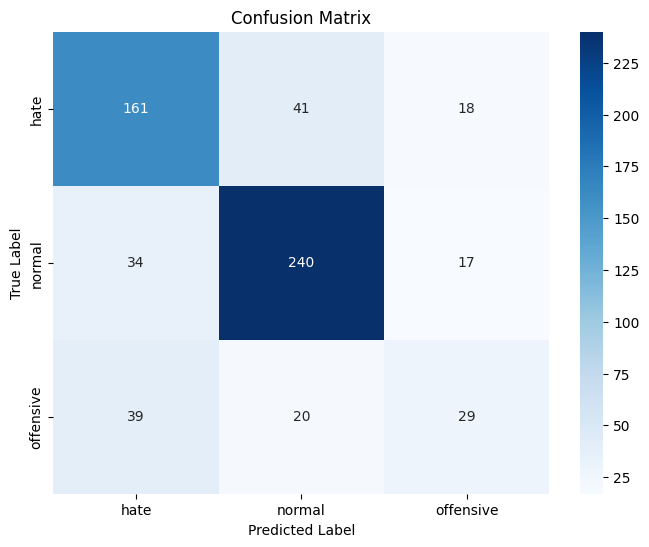

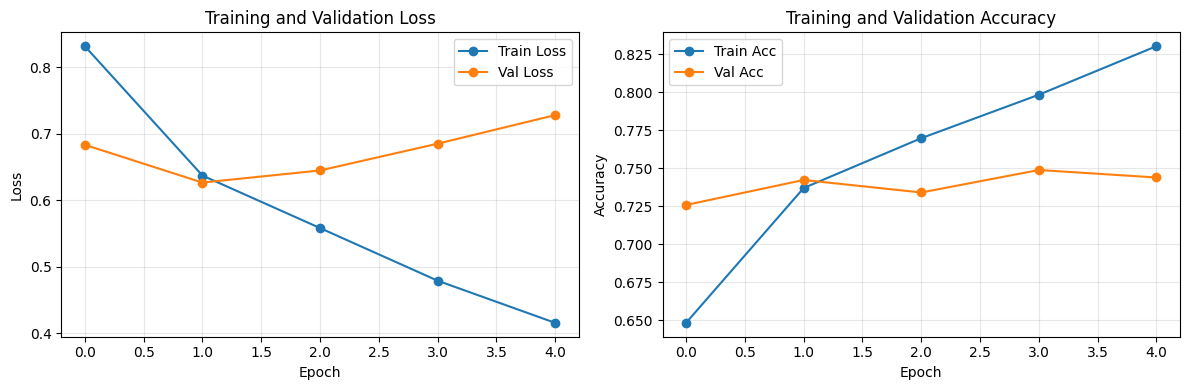

In [13]:
# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = eval_model(
    model, test_loader, loss_fn, device
)

print(f"\n{'='*50}")
print("Test Set Results")
print(f"{'='*50}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(
    test_labels,
    test_preds,
    target_names=['hate', 'normal', 'offensive']
))

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['hate', 'normal', 'offensive'],
            yticklabels=['hate', 'normal', 'offensive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
import os
from datetime import datetime

# Create directory for saving model
save_dir = "hindi_text_classifier"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the model and tokenizer
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"Model saved to {save_dir}")

# Save additional metadata
import json

metadata = {
    "model_name": MODEL_NAME,
    "num_classes": 3,
    "class_mapping": label_mapping,
    "training_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "test_accuracy": float(test_acc),
    "best_val_accuracy": float(best_accuracy)
}

with open(os.path.join(save_dir, "metadata.json"), "w") as f:
    json.dump(metadata, f, indent=4)

print("Metadata saved")

# Option 1: Download the entire folder (for Google Colab)
!zip -r hindi_text_classifier.zip {save_dir}

# Option 2: Save to Google Drive (if mounted)
try:
    from google.colab import drive
    drive.mount('/content/drive')

    # Copy to Google Drive
    drive_save_path = "/content/drive/MyDrive/hindi_text_classifier"
    !cp -r {save_dir} {drive_save_path}
    print(f"Model also saved to Google Drive: {drive_save_path}")
except:
    print("Google Drive not mounted or not in Colab")

Model saved to hindi_text_classifier
Metadata saved
  adding: hindi_text_classifier/ (stored 0%)
  adding: hindi_text_classifier/sentencepiece.bpe.model (deflated 49%)
  adding: hindi_text_classifier/model.safetensors (deflated 28%)
  adding: hindi_text_classifier/special_tokens_map.json (deflated 52%)
  adding: hindi_text_classifier/tokenizer.json (deflated 76%)
  adding: hindi_text_classifier/tokenizer_config.json (deflated 76%)
  adding: hindi_text_classifier/config.json (deflated 51%)
  adding: hindi_text_classifier/metadata.json (deflated 38%)
Google Drive not mounted or not in Colab


In [16]:
# Function to load saved model and make predictions
def load_and_test_model(model_path):
    """Load saved model and test it"""

    # Load metadata first
    with open(os.path.join(model_path, "metadata.json"), "r") as f:
        metadata = json.load(f)

    print(f"Model metadata: {metadata}")

    # Load tokenizer - use the original model name, not the saved directory
    # This is important for proper tokenizer loading
    try:
        # First try to load from saved directory
        tokenizer = AutoTokenizer.from_pretrained(model_path)
    except Exception as e:
        print(f"Warning: Could not load tokenizer from {model_path}: {e}")
        print("Loading tokenizer from original model name...")
        # Load from original model name
        original_model_name = metadata.get("model_name", "xlm-roberta-base")
        tokenizer = AutoTokenizer.from_pretrained(original_model_name)

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path,
        num_labels=metadata.get("num_classes", 3),
        ignore_mismatched_sizes=True
    )
    model = model.to(device)
    model.eval()

    print(f"Model loaded from: {model_path}")
    print(f"Number of classes: {metadata.get('num_classes', 3)}")

    def predict_single(text):
        """Predict class for a single text"""
        # Tokenize
        encoding = tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )

        # Move to device
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Predict
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probabilities = torch.nn.functional.softmax(logits, dim=1)
            prediction = torch.argmax(logits, dim=1)

        # Get class name
        class_idx = prediction.cpu().item()
        class_name = metadata['class_mapping'].get(str(class_idx), f"Class {class_idx}")

        return {
            'text': text,
            'predicted_class': class_name,
            'class_id': class_idx,
            'probabilities': probabilities.cpu().numpy()[0],
            'confidence': probabilities.max().cpu().item()
        }

    def predict_batch(texts):
        """Predict classes for a batch of texts"""
        results = []
        for text in texts:
            results.append(predict_single(text))
        return results

    return predict_single, predict_batch, metadata

# Test the saved model
print("Testing saved model...")

# Path to saved model
model_path = "hindi_text_classifier"

# Check if model directory exists
if os.path.exists(model_path):
    print(f"Model directory found: {model_path}")

    # List files in the directory
    print("Files in model directory:")
    for file in os.listdir(model_path):
        print(f"  - {file}")
else:
    print(f"Error: Model directory not found: {model_path}")
    print("Please make sure the model was saved correctly.")

# Load model
try:
    predict_single, predict_batch, metadata = load_and_test_model(model_path)

    # Test with sample texts
    test_samples = [
        "ये सुअर है बम विस्फोट कांड कर देता तेरे घर में",
        "आज ये बात पक्की हो गई कि भगवा कलर मनहूस है",
        "कश्मीर का नाम सुनते ही आतंकवाद और पत्थरबाज",
        "राष्ट्रपति के अभिभाषण पर आज मेरा भाषण",
        "यह एक सामान्य वाक्य है जिसमें कोई आपत्तिजनक शब्द नहीं है"
    ]

    print("\n" + "="*50)
    print("Sample Predictions")
    print("="*50)

    for text in test_samples:
        result = predict_single(text)
        print(f"\nText: {text[:50]}...")
        print(f"Predicted: {result['predicted_class']}")
        print(f"Confidence: {result['confidence']:.2%}")
        print(f"Probabilities: {dict(zip(['hate', 'normal', 'offensive'], result['probabilities']))}")

except Exception as e:
    print(f"Error loading model: {e}")
    print("\nTrying alternative loading method...")

    # Alternative loading method
    from transformers import AutoModelForSequenceClassification, AutoTokenizer
    import torch

    # Load model directly
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")  # Use original model name

    model = model.to(device)
    model.eval()

    # Simple prediction function
    def simple_predict(text):
        encoding = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
        encoding = {k: v.to(device) for k, v in encoding.items()}

        with torch.no_grad():
            outputs = model(**encoding)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            pred = torch.argmax(probs, dim=1)

        return {
            'text': text,
            'prediction': label_mapping[pred.item()],
            'confidence': probs.max().item()
        }

    # Test
    test_text = "ये सुअर है बम विस्फोट कांड कर देता तेरे घर में"
    result = simple_predict(test_text)
    print(f"\nAlternative method result:")
    print(f"Text: {test_text}")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.2%}")

Testing saved model...
Model directory found: hindi_text_classifier
Files in model directory:
  - sentencepiece.bpe.model
  - model.safetensors
  - special_tokens_map.json
  - tokenizer.json
  - tokenizer_config.json
  - config.json
  - metadata.json
Model metadata: {'model_name': 'xlm-roberta-base', 'num_classes': 3, 'class_mapping': {'0': 'hate', '1': 'normal', '2': 'offensive'}, 'training_date': '2025-12-06 06:49:02', 'test_accuracy': 0.7220394736842105, 'best_val_accuracy': 0.7489035087719298}
Loading tokenizer from original model name...
Model loaded from: hindi_text_classifier
Number of classes: 3

Sample Predictions

Text: ये सुअर है बम विस्फोट कांड कर देता तेरे घर में...
Predicted: hate
Confidence: 94.31%
Probabilities: {'hate': np.float32(0.9431377), 'normal': np.float32(0.0019207273), 'offensive': np.float32(0.054941572)}

Text: आज ये बात पक्की हो गई कि भगवा कलर मनहूस है...
Predicted: normal
Confidence: 97.19%
Probabilities: {'hate': np.float32(0.018267592), 'normal': np.floa

In [18]:
# Create a simple inference class
class HindiTextClassifier:
    def __init__(self, model_path="hindi_text_classifier"):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Load metadata
        metadata_path = os.path.join(model_path, "metadata.json")
        if os.path.exists(metadata_path):
            with open(metadata_path, "r") as f:
                self.metadata = json.load(f)
            self.original_model_name = self.metadata.get('model_name', 'xlm-roberta-base')
        else:
            self.metadata = {}
            self.original_model_name = 'xlm-roberta-base'

        print(f"Loading tokenizer from: {self.original_model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(self.original_model_name)

        print(f"Loading model from: {model_path}")
        num_labels = self.metadata.get('num_classes', 3)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_path,
            num_labels=num_labels
        )

        self.model = self.model.to(self.device)
        self.model.eval()

        # Create label mapping
        self.id2label = {0: 'hate', 1: 'normal', 2: 'offensive'}  # Default
        if 'class_mapping' in self.metadata:
            self.id2label = {int(k): v for k, v in self.metadata['class_mapping'].items()}

        self.label2id = {v: k for k, v in self.id2label.items()}

        print(f"Model loaded successfully. Class mapping: {self.id2label}")

    def predict(self, text, return_probabilities=False):
        """Predict class for input text"""
        try:
            # Tokenize
            encoding = self.tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=128,
                return_tensors='pt'
            )

            # Move to device
            input_ids = encoding['input_ids'].to(self.device)
            attention_mask = encoding['attention_mask'].to(self.device)

            # Predict
            with torch.no_grad():
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                probabilities = torch.nn.functional.softmax(logits, dim=1)
                prediction = torch.argmax(logits, dim=1)

            # Prepare results
            class_id = prediction.cpu().item()
            class_name = self.id2label.get(class_id, f"Class {class_id}")
            confidence = probabilities.max().cpu().item()

            result = {
                'text': text,
                'prediction': class_name,
                'class_id': class_id,
                'confidence': float(confidence)
            }

            if return_probabilities:
                probs = probabilities.cpu().numpy()[0]
                result['probabilities'] = {
                    self.id2label.get(i, f"Class {i}"): float(probs[i])
                    for i in range(len(probs))
                }

            return result

        except Exception as e:
            print(f"Error during prediction: {e}")
            return {
                'text': text,
                'prediction': 'error',
                'confidence': 0.0,
                'error': str(e)
            }

    def predict_batch(self, texts, return_probabilities=False):
        """Predict classes for multiple texts"""
        results = []
        for text in texts:
            results.append(self.predict(text, return_probabilities))
        return results

# Test the classifier
print("\n" + "="*50)
print("Testing Hindi Text Classifier")
print("="*50)

try:
    classifier = HindiTextClassifier()

    test_texts = [
        "मोदी जी पागल है जो जल संरक्षण के पीछे पागल हुए जा रहे",
        "बंगाल में BJP सरकार नही है इस लिए सभी मीडिया वाले भाजपा के कार्यकर्ता बनकर काम कर रहे है",
        "My Speech today on President Address Debate in LOK Sabha",
        "यह ट्वीट बहुत ही आपत्तिजनक और नफरत फैलाने वाला है"
    ]

    for text in test_texts:
        result = classifier.predict(text, return_probabilities=True)
        print(f"\nText: {text[:60]}...")
        print(f"Prediction: {result['prediction']}")
        print(f"Confidence: {result['confidence']:.2%}")
        if 'probabilities' in result:
            print(f"Probabilities: {result['probabilities']}")

except Exception as e:
    print(f"Error creating classifier: {e}")
    print("\nTroubleshooting steps:")
    print("1. Make sure you ran the training blocks first")
    print("2. Check if 'hindi_text_classifier' directory exists")
    print("3. Check if the directory contains the model files")


Testing Hindi Text Classifier
Loading tokenizer from: xlm-roberta-base
Loading model from: hindi_text_classifier
Model loaded successfully. Class mapping: {0: 'hate', 1: 'normal', 2: 'offensive'}

Text: मोदी जी पागल है जो जल संरक्षण के पीछे पागल हुए जा रहे...
Prediction: offensive
Confidence: 60.18%
Probabilities: {'hate': 0.36003565788269043, 'normal': 0.03816435858607292, 'offensive': 0.6017999649047852}

Text: बंगाल में BJP सरकार नही है इस लिए सभी मीडिया वाले भाजपा के क...
Prediction: normal
Confidence: 67.18%
Probabilities: {'hate': 0.21752336621284485, 'normal': 0.6717755794525146, 'offensive': 0.1107010692358017}

Text: My Speech today on President Address Debate in LOK Sabha...
Prediction: normal
Confidence: 99.24%
Probabilities: {'hate': 0.00529587222263217, 'normal': 0.9923938512802124, 'offensive': 0.0023102767299860716}

Text: यह ट्वीट बहुत ही आपत्तिजनक और नफरत फैलाने वाला है...
Prediction: normal
Confidence: 92.79%
Probabilities: {'hate': 0.04879412800073624, 'normal': 0.9

In [19]:
# Save the classifier as a pickle file for easy loading
import pickle

# Save classifier
with open('hindi_classifier.pkl', 'wb') as f:
    pickle.dump(classifier, f)

print("Classifier saved as 'hindi_classifier.pkl'")

# Download the files
from google.colab import files

# Download the model files
files.download('hindi_classifier.pkl')
files.download('hindi_text_classifier.zip')

print("\nAll files downloaded successfully!")

Classifier saved as 'hindi_classifier.pkl'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


All files downloaded successfully!
